In [1]:
!pip install transformers
!pip install pytorch-lightning

In [28]:
from google.colab import files

uploaded = files.upload()


Saving vietnamese-stopwords.txt to vietnamese-stopwords.txt


# Import lib

In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import json
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import re
from nltk.tokenize import word_tokenize

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Visualize Data

In [3]:
# Load data from CSV file
df = pd.read_csv('raw_data_vietnambiz.csv', encoding='utf-8-sig')

In [4]:
df.head()

,Content,Label
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG


In [5]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    5567.000000
mean      644.208191
std       343.181176
min        56.000000
25%       421.000000
50%       549.000000
75%       759.000000
max      3498.000000
Name: Word Count, dtype: float64

In [6]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,86
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,57
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,86
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,2
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,160


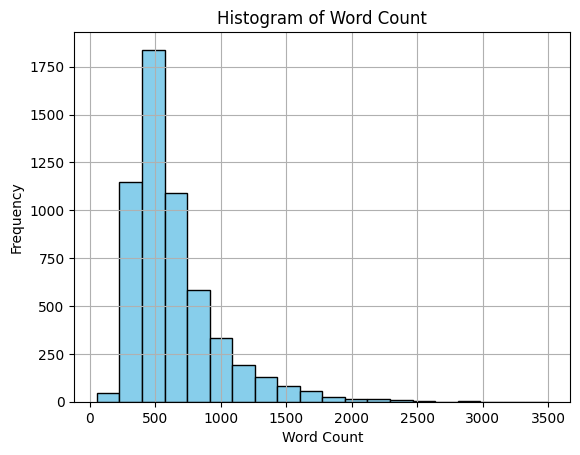

In [7]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

In [9]:
# extracted_df
e_df = df.loc[df['Class Count'] > 5].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        4892
Label          4892
Word Count     4892
Class Count    4892
dtype: int64

In [10]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

201

# Processing Dataset

## Clean text

In [11]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [23]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [ ]:
class ArticleDataset(Dataset):
    def __init__(self, data_path, labels, tokenizer, max_length):
        self.data_path = data_path
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article = self.articles[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text=article,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'article_text': article,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Model

In [ ]:
class ArticleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ArticleClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

# Load dataset and setup hyperparameters

In [ ]:
print(os.getcwd())

/content


In [ ]:
with open("raw_data_vietnambiz_1.json", 'r', encoding='utf-8') as f:
    articles = json.load(f)

In [ ]:
labels = set()

for item in articles:
    label = item.get("Label")
    if label:
        labels.add(label)
print(len(labels))

352


In [ ]:
articles = []
for item in articles:
    articles.append(item.get("Content"))

In [ ]:
le = LabelEncoder()
labels = le.fit_transform([i for i in labels])
labels = [i for i in labels]

In [ ]:
MAX_LENGTH = 512  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = len(labels)  # Replace with your actual number of classes
EPOCHS = 3

# Load phoBERT

In [34]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Create dataset

In [ ]:
# Create PyTorch Dataset
dataset = ArticleDataset(articles, labels, tokenizer, MAX_LENGTH)

In [ ]:
# Create PyTorch DataLoader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [ ]:
print(data_loader)

# Initialize Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Initialize our classifier
model = ArticleClassifier(N_CLASSES)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Setup Loss function and optimizer

In [ ]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


# Train Model

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    for step, batch in enumerate(data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()


Epoch 1/3
----------
Epoch 2/3
----------
Epoch 3/3
----------
